In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms, models
from datetime import datetime
from collections import OrderedDict
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

From [here](https://towardsdatascience.com/a-comprehensive-guide-to-image-augmentation-using-pytorch-fb162f2444be)
- augment images with rotation to get more images
- rbg to grayscale
- gaussian blur, random blocks, central region

In [7]:
class ResNetClassifier:
    def __init__(self, DATA_DIR, BATCH_SIZE=64, im_size=224):
        torch.manual_seed(0)

        self.BATCH_SIZE = BATCH_SIZE
        self.im_size = im_size
        self.DATADIR = DATA_DIR

    def train_val_test_split(self):
        """
        Load and process train, validation and test images.
        """
        # Define transforms for the training, validation, and testing sets
        training_transforms = transforms.Compose(
            [
                transforms.RandomRotation(30),
                transforms.RandomResizedCrop(self.im_size),
                transforms.RandomHorizontalFlip(),
                transforms.RandomGrayscale(p=0.5),
                transforms.RandomVerticalFlip(),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
            ]
        )

        validation_transforms = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(self.im_size),
                transforms.ToTensor(),
            ]
        )

        testing_transforms = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(self.im_size),
                transforms.ToTensor(),
            ]
        )

        # Load data
        # Double size of train data
        train_data = datasets.ImageFolder(
            self.DATADIR + "train", transform=training_transforms
        )
        dev_set = datasets.ImageFolder(
            self.DATADIR + "train", transform=training_transforms
        )
        train_data = ConcatDataset([train_data, dev_set])

        val_data = datasets.ImageFolder(
            self.DATADIR + "val", transform=validation_transforms
        )
        test_data = datasets.ImageFolder(
            self.DATADIR + "test", transform=testing_transforms
        )

        # Creating data samplers and loaders:
        self.train_loader = DataLoader(
            train_data, batch_size=self.BATCH_SIZE, shuffle=True
        )
        self.val_loader = DataLoader(val_data, batch_size=self.BATCH_SIZE, shuffle=True)
        self.test_loader = DataLoader(
            test_data, batch_size=self.BATCH_SIZE, shuffle=False
        )

        # Label mapping
        self.class_mapping = test_data.class_to_idx

    def build_model(self):
        self.model = models.resnet50(pretrained=True)

        # Freeze pretrained model parameters to avoid backpropogating through them
        for parameter in self.model.parameters():
            parameter.requires_grad = False

        # Build custom classifier
        self.num_classes = len(self.class_mapping)
        num_ftrs = self.model.fc.in_features
        classifier = nn.Sequential(
            OrderedDict(
                [
                    ("fcq", nn.Linear(num_ftrs, self.num_classes)),
                    ("output", nn.LogSoftmax(dim=1)),
                ]
            )
        )
        self.model.fc = classifier

        # Loss function and gradient descent
        self.criterion = nn.NLLLoss()
        self.optimizer = torch.optim.SGD(self.model.fc.parameters(), lr=0.1, momentum=0.9)
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min')
        # self.optimizer = optim.Adam(self.model.fc.parameters(), lr=0.001)

    def validation(self):
        val_loss = 0
        accuracy = 0

        for images, labels in iter(self.val_loader):
            output = self.model.forward(images)
            val_loss += self.criterion(output, labels).item()

            probabilities = torch.exp(output)

            equality = labels.data == probabilities.max(dim=1)[1]
            accuracy += equality.type(torch.FloatTensor).mean()

        return val_loss, accuracy

    def train_classifier(self, epochs=5):
        plot_training = []
        plot_validation = []

        for e in range(epochs):
            self.model.train()
            running_loss = 0

            for images, labels in iter(self.train_loader):
                self.optimizer.zero_grad()

                output = self.model.forward(images)
                loss = self.criterion(output, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            # Evaluate performance of each epoch
            self.model.eval()

            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                validation_loss, accuracy = self.validation()
                self.scheduler.step(validation_loss)

            print(
                "Epoch: {}/{}.. ".format(e + 1, epochs),
                "Training Loss: {:.3f}.. ".format(running_loss),
                "Validation Loss: {:.3f}.. ".format(
                    validation_loss / len(self.val_loader)
                ),
                "Validation Accuracy: {:.3f}".format(accuracy / len(self.val_loader)),
            )

            plot_training.append(running_loss)
            plot_validation.append(validation_loss / len(self.val_loader))

        plt.plot(range(len(plot_training)), plot_training, label='training')
        plt.plot(range(len(plot_validation)), plot_validation, label='validation')
        plt.legend()
        plt.show()

    def test_accuracy(self):
        self.model.eval()

        with torch.no_grad():
            accuracy = 0

            for images, labels in iter(self.test_loader):
                output = self.model.forward(images)
                probabilities = torch.exp(output)
                equality = labels.data == probabilities.max(dim=1)[1]
                accuracy += equality.type(torch.FloatTensor).mean()

            self.test_accuracy = accuracy / len(self.test_loader)
            print("Test Accuracy: {}".format(self.test_accuracy))

    def save_checkpoint(self, arch):
        """
        Input:
        arch(str): Model architecture
        """

        self.model.class_to_idx = self.class_mapping

        checkpoint = {
            "arch": arch,
            "class_to_idx": self.model.class_to_idx,
            "model_state_dict": self.model.state_dict(),
            "test_accuracy": self.test_accuracy,
        }

        timestamp = datetime.now().date().strftime("%Y%m%d")
        torch.save(checkpoint, f"../checkpoint/{timestamp}_{arch}.pth")

    def load_checkpoint(self, filepath):
        """
        Loads a checkpoint and rebuilds the model.

        Input:
        filepath(str): Relative path to model checkpoint
        """
        if os.path.exists(filepath):
            checkpoint = torch.load(filepath)

            if checkpoint["arch"] == "resnet18":
                self.model = models.resnet18(pretrained=True)

                for param in self.model.parameters():
                    param.requires_grad = False
            else:
                print("Architecture not recognized.")

            self.model.class_to_idx = checkpoint["class_to_idx"]
            self.model.load_state_dict(checkpoint["model_state_dict"])
        else:
            print("No such checkpoint found.")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\lilia/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch: 1/50..  Training Loss: 589.410..  Validation Loss: 6.917..  Validation Accuracy: 0.509
Epoch: 2/50..  Training Loss: 253.698..  Validation Loss: 6.626..  Validation Accuracy: 0.507
Epoch: 3/50..  Training Loss: 150.403..  Validation Loss: 7.240..  Validation Accuracy: 0.490
Epoch: 4/50..  Training Loss: 165.548..  Validation Loss: 8.303..  Validation Accuracy: 0.459
Epoch: 5/50..  Training Loss: 174.306..  Validation Loss: 10.144..  Validation Accuracy: 0.392
Epoch: 6/50..  Training Loss: 157.385..  Validation Loss: 14.210..  Validation Accuracy: 0.342
Epoch: 7/50..  Training Loss: 153.678..  Validation Loss: 8.282..  Validation Accuracy: 0.421
Epoch: 8/50..  Training Loss: 148.243..  Validation Loss: 7.643..  Validation Accuracy: 0.449
Epoch: 9/50..  Training Loss: 120.485..  Validation Loss: 7.265..  Validation Accuracy: 0.482
Epoch: 10/50..  Training Loss: 153.292..  Validation Loss: 13.280..  Validation Accuracy: 0.412
Epoch: 11/50..  Training Loss: 142.802..  Validation Los

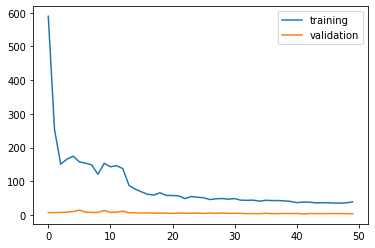

In [8]:
resnet = ResNetClassifier("../img/output/")
resnet.train_val_test_split()
resnet.build_model()
resnet.train_classifier(50)

In [9]:
resnet.test_accuracy()

Test Accuracy: 0.575316846370697


In [10]:
resnet.save_checkpoint('resnet50_double_train')

In [22]:
resnet = ResNetClassifier("../img/output/")
resnet.train_val_test_split()

c:\Users\lilia\Documents\rock-classification\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1/100..  Training Loss: 353.325..  Validation Loss: 15.422..  Validation Accuracy: 0.479
Epoch: 2/100..  Training Loss: 227.682..  Validation Loss: 9.969..  Validation Accuracy: 0.492
Epoch: 3/100..  Training Loss: 119.519..  Validation Loss: 9.825..  Validation Accuracy: 0.472
Epoch: 4/100..  Training Loss: 92.411..  Validation Loss: 9.395..  Validation Accuracy: 0.451
Epoch: 5/100..  Training Loss: 71.255..  Validation Loss: 5.746..  Validation Accuracy: 0.529
Epoch: 6/100..  Training Loss: 83.384..  Validation Loss: 7.648..  Validation Accuracy: 0.486
Epoch: 7/100..  Training Loss: 72.883..  Validation Loss: 11.846..  Validation Accuracy: 0.401
Epoch: 8/100..  Training Loss: 73.664..  Validation Loss: 7.341..  Validation Accuracy: 0.534
Epoch: 9/100..  Training Loss: 65.812..  Validation Loss: 5.403..  Validation Accuracy: 0.609
Epoch: 10/100..  Training Loss: 63.792..  Validation Loss: 5.909..  Validation Accuracy: 0.517
Epoch: 11/100..  Training Loss: 61.991..  Validation L

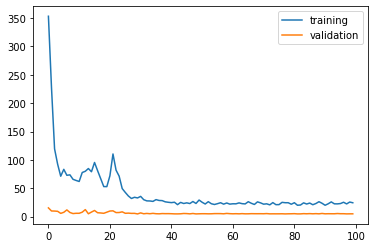

In [23]:
resnet.build_model()
resnet.train_classifier(100)

In [8]:
def build_model():
    resnet.model = models.resnet18(pretrained=True)

    # Freeze pretrained model parameters to avoid backpropogating through them
    for parameter in resnet.model.parameters():
        parameter.requires_grad = False

    # Build custom classifier
    resnet.num_classes = len(resnet.class_mapping)
    num_ftrs = resnet.model.fc.in_features
    classifier = nn.Sequential(
        OrderedDict(
            [
                ("fc1", nn.Linear(num_ftrs, 200)),
                ("fc2", nn.ReLU(nn.Linear(200, resnet.num_classes))),
                ("output", nn.LogSoftmax(dim=1)),
            ]
        )
    )
    resnet.model.fc = classifier

    # Loss function and gradient descent
    resnet.criterion = nn.NLLLoss()
    resnet.optimizer = optim.Adam(resnet.model.fc.parameters(), lr=0.001)

build_model()
resnet.train_classifier(15)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\lilia/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 10.3MB/s]


Epoch: 1/15..  Training Loss: 122.886..  Validation Loss: 2.660..  Validation Accuracy: 0.379
Epoch: 2/15..  Training Loss: 96.192..  Validation Loss: 2.372..  Validation Accuracy: 0.512
Epoch: 3/15..  Training Loss: 87.540..  Validation Loss: 2.254..  Validation Accuracy: 0.544
Epoch: 4/15..  Training Loss: 85.245..  Validation Loss: 2.211..  Validation Accuracy: 0.534
Epoch: 5/15..  Training Loss: 82.368..  Validation Loss: 2.155..  Validation Accuracy: 0.549
Epoch: 6/15..  Training Loss: 80.603..  Validation Loss: 2.115..  Validation Accuracy: 0.558
Epoch: 7/15..  Training Loss: 78.490..  Validation Loss: 2.109..  Validation Accuracy: 0.552
Epoch: 8/15..  Training Loss: 77.644..  Validation Loss: 2.087..  Validation Accuracy: 0.552
Epoch: 9/15..  Training Loss: 77.095..  Validation Loss: 2.104..  Validation Accuracy: 0.544
Epoch: 10/15..  Training Loss: 76.650..  Validation Loss: 2.112..  Validation Accuracy: 0.545
Epoch: 11/15..  Training Loss: 76.207..  Validation Loss: 2.071..  V

In [ ]:
# plot loss until it plateaus

In [5]:
def build_model():
    resnet.model = models.resnet50(weights=True)

    # Freeze pretrained model parameters to avoid backpropogating through them
    for parameter in resnet.model.parameters():
        parameter.requires_grad = False

    # Build custom classifier
    resnet.num_classes = len(resnet.class_mapping)
    num_ftrs = resnet.model.fc.in_features
    classifier = nn.Sequential(
        OrderedDict(
            [
                ("fc1", nn.Linear(num_ftrs, 200)),
                ("fc2", nn.ReLU(nn.Linear(200, resnet.num_classes))),
                ("output", nn.LogSoftmax(dim=1)),
            ]
        )
    )
    resnet.model.fc = classifier

    # Loss function and gradient descent
    resnet.criterion = nn.NLLLoss()
    resnet.optimizer = optim.Adam(resnet.model.fc.parameters(), lr=0.001)

build_model()
resnet.train_classifier()

TypeError: __init__() got an unexpected keyword argument 'weights'

In [14]:
def build_model():
    resnet.model = models.resnet18(weights=True)

    # Freeze pretrained model parameters to avoid backpropogating through them
    for parameter in resnet.model.parameters():
        parameter.requires_grad = False

    # Build custom classifier
    resnet.num_classes = len(resnet.class_mapping)
    num_ftrs = resnet.model.fc.in_features
    classifier = nn.Sequential(
        OrderedDict(
            [
                ('conv1', nn.ReLU(nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1))),
                ('pool1', nn.MaxPool2d(2,2)),
                ("fc1", nn.ReLU(nn.Linear(resnet.im_size**2 * 10, resnet.num_classes))),
                ("output", nn.LogSoftmax(dim=1)),
            ]
        )
    )
    resnet.model.fc = classifier

    # Loss function and gradient descent
    resnet.criterion = nn.NLLLoss()
    resnet.optimizer = optim.Adam(resnet.model.fc.parameters(), lr=0.001)

build_model()
resnet.train_classifier()

RuntimeError: non-empty 3D or 4D (batch mode) tensor expected for input